<a href="https://colab.research.google.com/github/rajaonsonella/csc2541_lab1/blob/main/lab1_post_module.ipynb?force_refresh=true" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC2541 - Lab 1: Deep Learning for structure-based drug design (SBDD)

Structure-based drug design (SBDD) aims at designing small-molecule ligands that bind with high affinity and specificity to pre-determined protein targets which have been identified as having therapeutic potential. Specifically, this approach focuses on leveraging the 3D structure of the protein target to rationally design a ligand.

In this lab, we aim at giving you an introduction to SBDD and the latest deep learning models used in the field. The lab is structured into three parts

### Table of Content

1.   Pre-module: Introduction to the Protein Data Bank (PDB) (~30 mins)
2.   Module: Exploring how ML does at Ligand pose prediction (~50 mins)
3.   Post-module (assignment): Evaluating a state of the art ML model (Boltz2) on various protein ligand complex pose prediction (~60 mins)

# Colab Set Up

In [1]:
!pip install numpy==1.26.4 boltz[cuda] py3Dmol ProDy

In [2]:
import numpy as np
np.__version__

'1.26.4'

In [3]:
import scipy
scipy.__version__

'1.13.1'

# Post-Module: Assessing co-folding methods capabilities on a case study

In the main module, we have seen that RMSD alone is not necessarily a good indicator of how well our models can predict a good ligand pose. For that reason, the community came up with simple packages that allow to check if other characteristics such as chemical validity are preserved.

In the post-module, we would like to introduce the state of the art models in structure-based drug design so called "co-folding" models and evaluate their prediction. Before jumping into the practice, let's first review what these models are.

### Co-folding models

Co-folding -- originally developed as part of the DragonFold project at Charm Therapeutics -- builds on the protein structure prediction concepts pioneered by the team at DeepMind working on AlphaFold.

While early methods like AlphaFold2 and RoseTTAFold could “only” predict protein structures, these newer approaches can not only determine protein structures *but also* generate the structures of bound ligands.

Co-folding methods use a training set of structures from the PDB to learn the relationship between a protein structure and a corresponding bound ligand. The model learned from the training set is then used to generate the structures of new complexes.

The field is very excited about these methods as target-ligand co-folding methods may be able to surpass classical methods like docking and even replace physics-based free energy perturbation approaches, which demand computationally expensive molecular dynamics simulations and force field optimizations.


Regarding the PoseBusters Benchmark we have seen in the previous module, models like AlphaFold3 have recently achieved very good performance on it

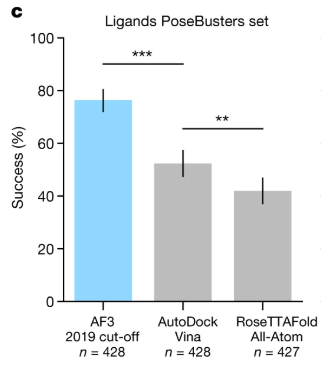

In this post-module, we are going to have a look at Boltz-2, the latest open-source co-folding model


For this module, we are going to look at

>
> Protein:
> * PDB ID: 7XKJ


### Step 1: Prepare the Boltz2 input

Given your group, create a file according to the instructions found [here](https://github.com/jwohlwend/boltz/blob/main/docs/prediction.md)

Upload this file to colab and name it ```boltz_input.yaml```

In [ ]:
#TODO: Create the YAML file. To help you, have a look at the information on RCSB-PDB

### Step 2: Run Boltz2

In [63]:
#@title Run prediction using Boltz-2
#@markdown YAML filename
yaml_filename = 'boltz_input' #@param {type:"string"}
#@markdown Output format
output_format = 'mmcif' #@param ["pdb", "mmcif"]
#@markdown Number of dataloader workers
num_workers = 0 #@param {type:"slider", min:0, max:5, step:1}
#@markdown Lower the step scale to increase the diversity of result. (default: 1.638)
step_scale = 1.638 #@param {type:"slider", min:1, max:2, step:0.001}
#@markdown Number of diffusion samples to be generated. (default: 1, AlphaFold3: 5)
diffusion_samples = 1 #@param {type:"slider", min:1, max:10, step:1}
#@markdown Number of recycling steps for the prediction. (default: 3, AlphaFold3: 10)
recycling_steps = 3 #@param {type:"slider", min:1, max:25, step:1}
#@markdown Number of sampling steps for structure prediction. (default: 200)
sampling_steps = 50 #@param {type:"slider", min:50, max:400, step:50}
#@markdown Maximum number of MSA sequences to be used
max_msa_seqs = 8192 #@param [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
#@markdown Subsample MSA?
subsample_msa = False #@param {type:"boolean"}
#@markdown Number of subsampled MSA
num_subsampled_msa = 1024 #@param [4, 8, 16, 32, 64, 128, 256, 512, 1024]
#@markdown MSA pairing strategy
msa_pairing_strategy = 'greedy' #@param ['greedy', 'complete']
#@markdown Use GPU
device = 'gpu' #@param ['gpu', 'cpu']

commandline = f'{yaml_filename}.yaml --override --num_workers {num_workers} --step_scale {step_scale} --recycling_steps {recycling_steps} --sampling_steps {sampling_steps}'
commandline += f' --diffusion_samples {diffusion_samples} --max_msa_seqs {max_msa_seqs} --msa_pairing_strategy {msa_pairing_strategy} --use_msa_server'
if subsample_msa:
    commandline += f' --num_subsampled_msa {num_subsampled_msa}'
if device == "gpu":
    commandline += ' --no_kernels --accelerator gpu'
else:
    commandline += ' --accelerator cpu'

!boltz predict {commandline} --out_dir /content/boltz_output

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
MSA server enabled: https://api.colabfold.com
MSA server authentication: no credentials provided
Checking input data.
All inputs are already processed.
Processing 0 inputs with 0 threads.
0it [00:00, ?it/s]
Found 1 existing predictions, will override.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: F

### Step 4: Analyze the prediction results (Visual inspection & RMSD)

Let's analyze the prediction results visually first. To do so, we can do a quick and dirty alignment based on maximum Carbon Alpha matching of the predicted and reference structures.

In [4]:
import py3Dmol
import requests
from IPython.display import display
from pathlib import Path

def view_cif(cif_path, width=800, height=600):
    import py3Dmol

    view = py3Dmol.view(width=width, height=height)
    with open(cif_path) as f:
        view.addModel(f.read(), "cif")

    view.setBackgroundColor("white")

    # Cartoon for protein (CIF-safe)
    view.setStyle({}, {"cartoon": {"color": "spectrum"}})

    # Sticks for non-polymer atoms (ligands)
    view.addStyle(
        {"hetflag": True},
        {"stick": {"radius": 0.25}}
    )

    view.addStyle(
        {"hetflag": True, "bond": 0},  # atoms with no bonds are usually ions
        {"sphere": {"radius": 0.5, "color": "green"}}
    )

    view.zoomTo()
    return view

def compare_cifs(
    cif_a,
    cif_b,
    width=900,
    height=650,
):
    import py3Dmol

    view = py3Dmol.view(width=width, height=height)
    view.setBackgroundColor("white")

    # --- Load first CIF (model 0) ---
    with open(cif_a) as f:
        view.addModel(f.read(), "cif")

    # --- Load second CIF (model 1) ---
    with open(cif_b) as f:
        view.addModel(f.read(), "cif")

    # ===== Protein cartoons =====
    view.setStyle(
        {"model": 0},
        {"cartoon": {"color": "blue"}}
    )

    view.setStyle(
        {"model": 1},
        {"cartoon": {"color": "orange", "opacity": 0.6}}
    )

    # ===== Ligands / hetero atoms =====
    view.addStyle(
        {"model": 0, "hetflag": True},
        {"stick": {"radius": 0.25, "color": "blue"}}
    )

    view.addStyle(
        {"model": 1, "hetflag": True},
        {"stick": {"radius": 0.25, "color": "orange"}}
    )

    view.zoomTo()
    return view

# Download a PDB file
def download_pdb_file(pdb_id: str) -> str:
    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(filename, 'w').write(pdb_req.text)
    return filename

def download_cif_file(cif_id: str) -> str:
    """
    Download a structure as CIF / mmCIF.

    Accepts:
    - URL
    - local .cif file
    - RCSB PDB ID (e.g. 7XKJ)
    - AlphaFold ID (AF-XXXX)
    """
    # URL provided
    if cif_id.startswith("http"):
        url = cif_id
        filename = Path(url).name

    # Local CIF
    elif cif_id.endswith(".cif"):
        return cif_id

    # AlphaFold model
    elif cif_id.startswith("AF"):
        url = f"https://alphafold.ebi.ac.uk/files/{cif_id}-model_v3.cif"
        filename = f"{cif_id}.cif"

    # RCSB PDB entry → mmCIF
    else:
        pdb_id = cif_id.upper()
        url = f"https://files.rcsb.org/download/{pdb_id}.cif"
        filename = f"{pdb_id}.cif"

    resp = requests.get(url)
    resp.raise_for_status()

    with open(filename, "w") as f:
        f.write(resp.text)

    return filename

Here is our predicted structure!

In [5]:
yaml_filename = "7xkj_input"

In [6]:
cif_file = f"/content/boltz_output/boltz_results_{yaml_filename}/predictions/{yaml_filename}/{yaml_filename}_model_0.cif"
view = view_cif(cif_file)
display(view)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Let's download the reference structure from RCSB-PDB

In [49]:
# @markdown > Enter the PDB ID here to source the starting structure of receptor. This PDB file will be pulled from RCSB PDB server.
# Download CIF file
pdb_code = "7XKJ" #@param {type:"string"}
download_cif_file(pdb_code)
download_pdb_file(pdb_code)

'7XKJ.pdb'

Now, let's align both

In [55]:
from prody import parsePDB, parseMMCIF, calcTransformation, calcRMSD, writeMMCIF

def align_structured_and_compute_rmsd(mobile_file, reference_file, out_path="aligned_mobile.cif"):
    # Load structures
    parser = parseMMCIF if mobile_file.endswith(".cif") else parsePDB
    mob = parser(mobile_file)
    parser = parseMMCIF if reference_file.endswith(".cif") else parsePDB
    ref = parser(reference_file)

    # Select CA atoms
    sel_str = "protein and name CA"

    mob_sel = mob.select(sel_str)
    ref_sel = ref.select(sel_str)

    if mob_sel is None or ref_sel is None:
        raise ValueError("Selection returned no atoms.")

    # Build dicts keyed by (chain, resnum, atomname) -> index in selection
    mob_dict = {(atom.getChid(), atom.getResnum(), atom.getName()): i for i, atom in enumerate(mob_sel)}
    ref_dict = {(atom.getChid(), atom.getResnum(), atom.getName()): i for i, atom in enumerate(ref_sel)}

    # Find overlapping CA atoms
    common_keys = mob_dict.keys() & ref_dict.keys()
    if not common_keys:
        raise ValueError("No matching atoms found.")

    mob_indices = [mob_dict[k] for k in common_keys]
    ref_indices = [ref_dict[k] for k in common_keys]

    # Create subsets (AtomGroups) of matching CA atoms
    mob_common = mob_sel[mob_indices]
    ref_common = ref_sel[ref_indices]

      # Compute and apply 3D transformation
    trans = calcTransformation(mob_common, ref_common)
    trans.apply(mob)
    writeMMCIF(out_path, mob)

    # Compute RMSD
    rmsd = calcRMSD(mob_common, ref_common)

    print(f"RMSD on {len(common_keys)} matching CA atoms: {rmsd:.3f} Å")


In [56]:
align_structured_and_compute_rmsd(
    mobile_file=f"/content/boltz_output/boltz_results_{yaml_filename}/predictions/{yaml_filename}/{yaml_filename}_model_0.cif",
    reference_file=f"/content/{pdb_code}.cif",
    out_path="/content/boltz_prediction_aligned_2.cif",
)

# Visualize aligned structure in py3Dmol
view = compare_cifs(
    "boltz_prediction_aligned_2.cif",
    f"/content/{pdb_code}.cif",
)
display(view)

@> 1573 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1573 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1406 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1406 atoms and 1 coordinate set(s) were parsed in 0.03s.


RMSD on 168 matching CA atoms: 0.468 Å


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#TODO: Why is the RMSD metric given above not to be trusted for final conclusions on prediction quality?

Let's calculate the ligand RMSD independently

In [45]:
from prody import parsePDB, parseMMCIF, calcTransformation, calcRMSD, writePDB
from rdkit import Chem
import os


def write_selection_to_sdf(selection, sdf_filename):
    """Helper: ProDy selection to SDF format via RDKit"""
    tmp_pdb = sdf_filename.replace(".sdf", ".pdb")

    writePDB(tmp_pdb, selection)

    mol = Chem.MolFromPDBFile(
        tmp_pdb,
        removeHs=False,
        sanitize=False
    )

    if mol is None:
        raise RuntimeError(f"RDKit failed to read {tmp_pdb}")

    writer = Chem.SDWriter(sdf_filename)
    writer.write(mol)
    writer.close()

    os.remove(tmp_pdb)


def ligand_rmsd_only(mobile_file, reference_file, ligand_name_match, save_to_sdf=True):
    # Load structures
    parser = parseMMCIF if mobile_file.endswith(".cif") else parsePDB
    mob = parser(mobile_file)

    parser = parseMMCIF if reference_file.endswith(".cif") else parsePDB
    ref = parser(reference_file)

    for ligand_id, ref_ligand_id in ligand_name_match.items():

        # Select ligand atoms (exclude water explicitly)
        mob_sel = mob.select(f"resname {ligand_id} and not water")
        ref_sel = ref.select(f"resname {ref_ligand_id} and not water")

        if mob_sel is None or ref_sel is None:
            raise ValueError(f"Ligand selection failed for {ligand_id}")

        if mob_sel.numAtoms() != ref_sel.numAtoms():
            raise ValueError(
                f"Atom count mismatch for {ligand_id}: "
                f"{mob_sel.numAtoms()} vs {ref_sel.numAtoms()}"
            )

        # Compute and apply transformation
        trans = calcTransformation(mob_sel, ref_sel)
        trans.apply(mob)

        # RMSD
        rmsd = calcRMSD(mob_sel, ref_sel)

        print(
            f"RMSD for {ligand_id} (CCD: {ref_ligand_id}): "
            f"{rmsd:.3f} Å"
        )

        # Save to SDF
        if save_to_sdf:
          write_selection_to_sdf(
              mob_sel,
              f"ligand_{ligand_name_match[ligand_id]}_boltz.sdf"
          )

          write_selection_to_sdf(
              ref_sel,
              f"ligand_{ligand_name_match[ligand_id]}_reference.sdf"
          )


In [46]:
ligand_rmsd_only(
    mobile_file=f"/content/boltz_output/boltz_results_{yaml_filename}/predictions/{yaml_filename}/{yaml_filename}_model_0.cif",
    reference_file=f"/content/{pdb_code}.cif",
    ligand_name_match={"LIG1": "6IC", "LIG2": "GDP", "LIG3": "MG"}, #To circumvent Boltz2 ligand naming issue: https://github.com/jwohlwend/boltz/issues/630
)

@> 1573 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:1573 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 1406 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1406 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> WARNING Resname LIG1 too long, cutting resname to 3 characters as LIG
@> WARNING Resname LIG2 too long, cutting resname to 3 characters as LIG
@> WARNING Resname LIG3 too long, cutting resname to 3 characters as LIG


RMSD for LIG1 (CCD: 6IC): 6.167 Å
RMSD for LIG2 (CCD: GDP): 3.055 Å
RMSD for LIG3 (CCD: MG): 0.000 Å


In [ ]:
#TODO: Discuss the obtained results, and how this confirms your answer to the previous TODO

## Step 5: Look at PoseBusters accuracy on ligand structure

In [47]:
!pip install posebusters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.8/567.8 kB 4.5 MB/s eta 0:00:00


In [57]:
!bust ligand_6IC_boltz.sdf -l ligand_6IC_reference.sdf -p 7XKJ.pdb --outfmt long

Long summary for ligand_6IC_boltz.sdf  0
MOL_PRED loaded                          .   
MOL_TRUE loaded                          .   
MOL_COND loaded                          .   
Sanitization                             .   
InChI convertible                        .   
All atoms connected                      .   
No radicals                              .   
Molecular formula                        .   
Molecular bonds                          .   
Double bond stereochemistry              .   
Tetrahedral chirality                    Fail
Bond lengths                             .   
Bond angles                              .   
Internal steric clash                    .   
Aromatic ring flatness                   .   
Non-aromatic ring non-flatness           .   
Double bond flatness                     .   
Internal energy                          .   
Protein-ligand maximum distance          .   
Minimum distance to protein              Fail
Minimum distance to organic cofactors  

In [58]:
!bust ligand_GDP_boltz.sdf -l ligand_GDP_reference.sdf -p 7XKJ.pdb --outfmt long

[03:01:56] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[03:01:56] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[03:01:56] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[03:01:56] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[03:02:00] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[03:02:00] UFFTYPER: Warning: hybridization set to SP3 for atom 5
Long summary for ligand_GDP_boltz.sdf  0
MOL_PRED loaded                          .   
MOL_TRUE loaded                          .   
MOL_COND loaded                          .   
Sanitization                             .   
InChI convertible                        .   
All atoms connected                      .   
No radicals                              .   
Molecular formula                        .   
Molecular bonds                          .   
Double bond stereochemistry              .   
Tetrahedral chirality                    Fail
Bond lengths                             .   
Bond angles

In [ ]:
#TODO: Discuss the obtained results